# Week 2 Mini project
## Predicting copper future price 

### 1. Background

A copper future is a legally binding agreement to buy or sell a standard quantity of Grade-A cathode copper at a preset price for delivery (or cash‐settlement) on a future date. Producers hedge price risk, manufacturers lock-in costs, and speculators trade anticipated moves.

There are three major future exchanges that trade copper contracts, namely, Shanghai Futures Exchange (CU), London metal exchange (CA), and CME Group / COMEX Copper (HG). Copper contracts in the three exchanges often share similar prices but are almost never identical. This is because the three markets operate in different time, and are technically selling copper contrasts in different countries. A brief summary of the differences across the three exchanges can be found at the end of this document. 

In this project, we will try to leverage the three exchange markets as well as the abudant data on the Internet to build a predictive model for U.S. copper contract prices. 

> In a recent announcement, a $50\%$ tariff will be imposed on imported copper to U.S., which should drive up the U.S. copper contract price. However, according to [a news piece](https://www.reuters.com/markets/commodities/trumps-copper-tariffs-wont-lift-us-output-will-boost-costs-2025-07-10/) by Reuters: "U.S. copper contracts rose to a 26% premium over their London equivalent on Wednesday from a 13% premium before Trump's announcement. That 26% premium is still well short of the 50% tariff, likely indicating the uncertainty in the market as to what types of copper products will be subject to tariffs or the risk of a lower rate for some countries." 

### 2. Objective

The grand objective is simple: to build a model to predict the U.S. copper contracts price per day. You are free to fit any models or use any data you can find, as long as the model uses only data before the market opens on the day of interest (i.e., no data leakage). 

To get started, you can run the following cells to download the copper contract prices from the three exchanges. You might need to install some libraries if you see errors complaining on libraries found. 


In [14]:
%pip install yfinance
import yfinance as yf
import pandas as pd

# ------------------------------------------------------------
# 1.  Download daily front-month copper futures (COMEX)
# ------------------------------------------------------------
ticker = "HG=F"                # Copper continuous contract on Yahoo Finance
start  = "2010-01-01"          # any start date you like
end    = "2025-07-15"          # or leave end=None for “today”

NY = yf.download(ticker, start=start, end=end, interval="1d")

# Quick sanity-check
NY.head()


C:\Users\super\AppData\Local\Temp\ipykernel_26996\1926688803.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  NY = yf.download(ticker, start=start, end=end, interval="1d")
[*********************100%***********************]  1 of 1 completed

Note: you may need to restart the kernel to use updated packages.


Price,Close,High,Low,Open,Volume
Ticker,HG=F,HG=F,HG=F,HG=F,HG=F
Date,,,,,
2010-01-04,3.3880,3.4090,3.3530,3.3880,404
2010-01-05,3.3960,3.4110,3.3685,3.3960,242
2010-01-06,3.4775,3.4995,3.4335,3.4775,109
2010-01-07,3.4115,3.5235,3.4110,3.4995,326
2010-01-08,3.3880,3.4220,3.3800,3.3880,311


In [15]:
NY.tail()
NY['High'].info()
NY

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3905 entries, 2010-01-04 to 2025-07-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HG=F    3905 non-null   float64
dtypes: float64(1)
memory usage: 61.0 KB


Price,Close,High,Low,Open,Volume
Ticker,HG=F,HG=F,HG=F,HG=F,HG=F
Date,,,,,
2010-01-04,3.3880,3.4090,3.3530,3.3880,404
2010-01-05,3.3960,3.4110,3.3685,3.3960,242
2010-01-06,3.4775,3.4995,3.4335,3.4775,109
2010-01-07,3.4115,3.5235,3.4110,3.4995,326
2010-01-08,3.3880,3.4220,3.3800,3.3880,311
...,...,...,...,...,...
2025-07-08,5.6450,5.6450,4.9495,4.9680,922
2025-07-09,5.4435,5.6820,5.3975,5.4670,857


In [16]:
%pip install akshare
%pip install pandas_datareader

import akshare as ak
import datetime as dt
from pandas_datareader import data as web

MT_TO_LB = 2204.62262    
# main (dominant) copper contract from Sina Finance, date index ascending
SHFE = ak.futures_main_sina(symbol="CU0",end_date="20250715",start_date="20150101")   # "CU0" -> SHFE copper continuous
# rename to English
SHFE = SHFE.rename(columns={
    "日期": "date",
    "开盘价": "open",
    "最高价": "high",
    "最低价": "low",
    "收盘价": "close",
    "成交量": "volume",
    "持仓量": "open_interest",
    "动态结算价": "settlement_price"
})
# ---- FX: CNY per USD (daily) --------------------------------
fx = (
    web.DataReader(
        "DEXCHUS",      # Yuan per 1 USD (FRED)
        "fred",
        2005,
        2025  # or leave end=None for “today”
    )
    .rename(columns={"DEXCHUS": "cny_per_usd"})
    .ffill()                        # forward-fill weekends / holidays
)

# ---- merge & convert ----------------------------------------
SHFE.set_index("date", inplace=True)        # make 'date' the index
SHFE.sort_index(inplace=True)               # (optional) keep rows in chrono order

SHFE = SHFE.join(fx, how="left")
SHFE["usd_per_ton"] = SHFE["close"] / SHFE["cny_per_usd"]
SHFE["usd_per_lb"]  = SHFE["usd_per_ton"] / MT_TO_LB

SHFE.head()


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


,open,high,low,close,volume,open_interest,settlement_price,cny_per_usd,usd_per_ton,usd_per_lb
date,,,,,,,,,,
2015-01-05,45500,45570,44990,45080,189194,325160,45250,6.2201,7247.471906,3.287398
2015-01-06,44210,44910,43980,44800,447986,310542,44570,6.2125,7211.267606,3.270976
2015-01-07,44640,44840,44420,44650,317816,301058,44660,6.2127,7186.891368,3.259919
2015-01-08,44650,44890,44580,44680,208524,297932,44740,6.2143,7189.868529,3.261270
2015-01-09,45000,45050,44250,44250,384066,308602,44550,6.2085,7127.325441,3.232900


In [17]:
SHFE.tail()

,open,high,low,close,volume,open_interest,settlement_price,cny_per_usd,usd_per_ton,usd_per_lb
date,,,,,,,,,,
2025-07-09,79590,80170,78270,78400,162594,193999,78910,NaN,NaN,NaN
2025-07-10,78340,78680,78160,78600,99231,181068,78390,NaN,NaN,NaN
2025-07-11,78700,78810,78370,78430,81666,178678,78530,NaN,NaN,NaN
2025-07-14,78040,78520,78010,78400,79133,172200,78290,NaN,NaN,NaN
2025-07-15,77900,78160,77700,78090,81646,169903,77930,NaN,NaN,NaN


In [18]:
# The LME copper price is available MONTHLY from the IMF database
start = dt.datetime(1990, 1, 1)
LME= web.DataReader("PCOPPUSDM", "fred", start)   # IMF / LME cash price

LME.rename(columns={"PCOPPUSDM": "usd_per_ton"}, inplace=True)
LME["usd_per_lb"] = LME["usd_per_ton"] / MT_TO_LB

LME.head()  

,usd_per_ton,usd_per_lb
DATE,,
1990-01-01,2365.556991,1.072999
1990-02-01,2358.943400,1.069999
1990-03-01,2625.702723,1.190999
1990-04-01,2685.226891,1.217998
1990-05-01,2740.342391,1.242998


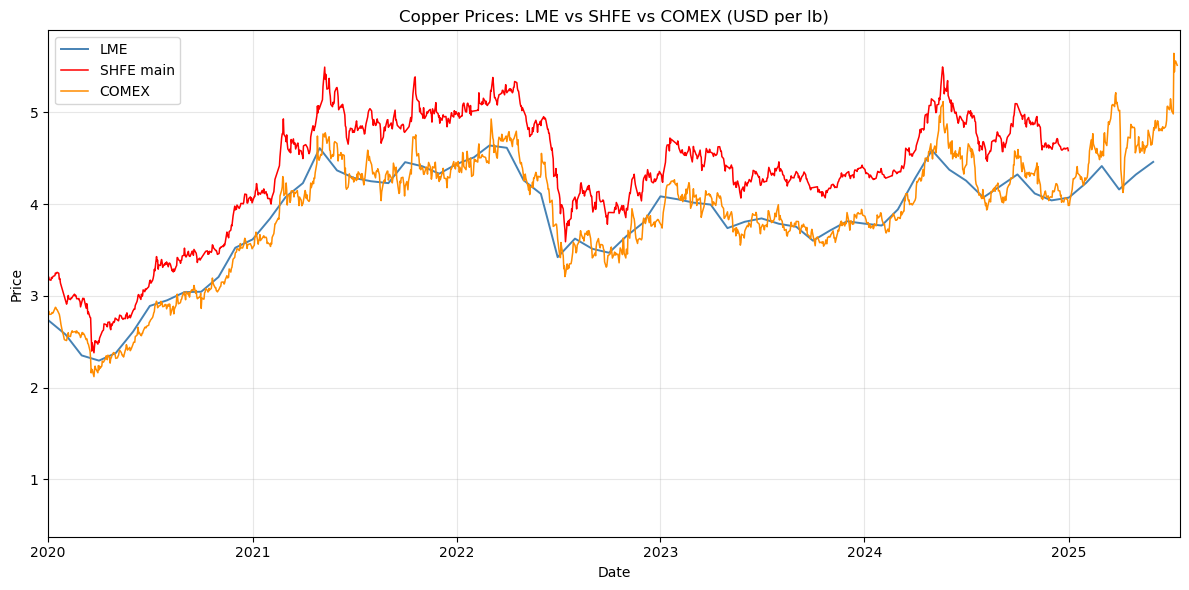

In [19]:

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.plot(LME.index, LME["usd_per_lb"],
         label="LME", linewidth=1.4, color="steelblue")

plt.plot(SHFE.index, SHFE["usd_per_lb"],
         label="SHFE main", linewidth=1.1, color="red")
plt.plot(NY.index, NY["Close"],
         label="COMEX", linewidth=1.1, color="darkorange")

plt.title("Copper Prices: LME vs SHFE vs COMEX (USD per lb)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
start_xlim = pd.Timestamp("2020-01-01")
end_xlim   = pd.Timestamp("2025-07-19")
plt.xlim(start_xlim, end_xlim)  
plt.show()

## Appendix: Summary of the three exchanges

| Exchange (venue code)                       | Contract unit        | Price quote   | Typical trading hours (local)         | Warehouse/delivery system                                   | Tick size                                                      |
| ------------------------------------------- | -------------------- | ------------- | ------------------------------------- | ----------------------------------------------------------- | -------------------------------------------------------------- |
| **London Metal Exchange – LME Copper (CA)** | 25 metric tonnes     | USD per tonne | 01:00-19:00 London (ring + LMEselect) | Global LME-approved sheds; *“warrants”* transferable        | USD 0.10/tonne ([Lme][1])                                      |
| **Shanghai Futures Exchange – SHFE 铜 (CU)** | 5 t                  | CNY per ton   | 09:00-15:00 & 21:00-02:00 Beijing     | Mainland China warehouses; VAT & import‐quota rules apply   | ¥10/ton (≈USD 1.4) ([tsite.shfe.com.cn][2], [Barchart.com][3]) |
| **CME Group / COMEX Copper (HG)**           | 25 000 lb (≈11.34 t) | USD ¢ per lb  | 18:00-17:00 ET (electronically)       | U.S. COMEX-licensed warehouses; deliverable Grade 1 cathode | USD 0.0005/lb ([CME Group][4], [CME Group][5])                 |

[1]: https://www.lme.com/en/metals/non-ferrous/lme-copper/contract-specifications?utm_source=chatgpt.com "Contract specifications | London Metal Exchange"
[2]: https://tsite.shfe.com.cn/eng/market/futures/metal/cu/index.html?utm_source=chatgpt.com "Copper"
[3]: https://www.barchart.com/futures/quotes/VC%2A0/profile?utm_source=chatgpt.com "SHFE Copper Aug '25 Futures Contract Specifications - Barchart.com"
[4]: https://www.cmegroup.com/markets/metals/base/copper.contractSpecs.html?utm_source=chatgpt.com "Copper Futures Contract Specs - CME Group"
[5]: https://www.cmegroup.com/markets/metals/base/copper.html?utm_source=chatgpt.com "Copper Futures Overview - CME Group"


In [20]:
from sklearn.model_selection import train_test_split

# Example: split NY (COMEX) data using 'Close' as target
X = NY.drop(columns=('Close'))
y = NY[('Close', 'HG=F')]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

Training set: (3124, 4) (3124,)
Validation set: (781, 4) (781,)


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [22]:
# --- Random Forest Regression for Copper Price Prediction New York ---

# --- Random Forest Regression for Copper Price Prediction New York ---

features = ['Open', 'High', 'Low', 'Volume']
X = NY[features]
y = NY['Close']
# Shift previous day's features
X['Open_prev'] = X['Open'].shift(1)
X['High_prev'] = X['High'].shift(1)
X['Low_prev'] = X['Low'].shift(1)
X['Volume_prev'] = X['Volume'].shift(1)

X = X.drop(X.index[0])
X.drop(columns=['High', 'Low', 'Volume'], inplace=True)
X = X.dropna()  # Remove rows with NaN values after shifting

X.head()

 # Remove rows with NaN values after shifting
#y.head()


C:\Users\super\AppData\Local\Temp\ipykernel_26996\3005394439.py:15: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X.drop(columns=['High', 'Low', 'Volume'], inplace=True)


Price,Open,Open_prev,High_prev,Low_prev,Volume_prev
Ticker,HG=F,,,,
Date,,,,,
2010-01-05,3.3960,3.3880,3.4090,3.3530,404.0
2010-01-06,3.4775,3.3960,3.4110,3.3685,242.0
2010-01-07,3.4995,3.4775,3.4995,3.4335,109.0
2010-01-08,3.3880,3.4995,3.5235,3.4110,326.0
2010-01-11,3.4285,3.3880,3.4220,3.3800,311.0


c:\Users\super\miniconda3\envs\cosmos\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


New York Copper Price Prediction using Random Forest
Random Forest MSE: 0.0113
Random Forest R2: 0.9413


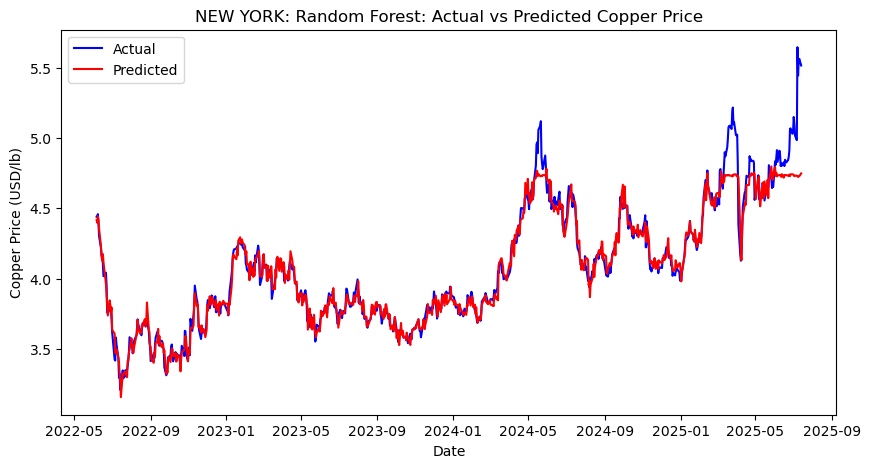

In [23]:
# The shifted columns are added as strings, not tuples
# The shifted columns are now strings, not tuples
model_features = ['Open_prev', 'High_prev', 'Low_prev', 'Volume_prev', 'Open']

X_model = X[model_features]
y_model = y.loc[X_model.index]

# Update X and y for train/test split
X = X_model
y = y_model
# Split data (already shown above, but for clarity)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_val)

# Evaluate
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print("New York Copper Price Prediction using Random Forest")
print(f"Random Forest MSE: {mse:.4f}")
print(f"Random Forest R2: {r2:.4f}")

# Plot actual vs predicted
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y_val.index, y_val, label='Actual', color='blue')
plt.plot(y_val.index, y_pred, label='Predicted', color='red')
plt.title('NEW YORK: Random Forest: Actual vs Predicted Copper Price')
plt.xlabel('Date')
plt.ylabel('Copper Price (USD/lb)')
plt.legend()
plt.show()

c:\Users\super\miniconda3\envs\cosmos\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


New York Copper Price Prediction using Random Forest
Random Forest MSE: 0.0061
Random Forest R2: 0.9682


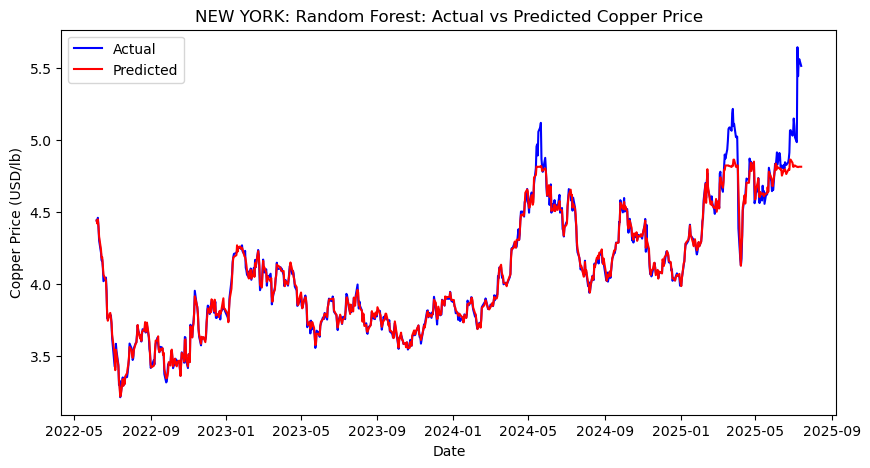

In [24]:
# --- Random Forest Regression for Copper Price Prediction Shanghai---

features = ['Open', 'High', 'Low', 'Volume']  # You can add more features if available
X = NY[features]
y = NY['Close']

# Split data (already shown above, but for clarity)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_val)

# Evaluate
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print("New York Copper Price Prediction using Random Forest")
print(f"Random Forest MSE: {mse:.4f}")
print(f"Random Forest R2: {r2:.4f}")

# Plot actual vs predicted
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y_val.index, y_val, label='Actual', color='blue')
plt.plot(y_val.index, y_pred, label='Predicted', color='red')
plt.title('NEW YORK: Random Forest: Actual vs Predicted Copper Price')
plt.xlabel('Date')
plt.ylabel('Copper Price (USD/lb)')
plt.legend()
plt.show()

In [25]:
# Evaluate
y_train_pred = rf.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_pred)
print(f"Random Forest Training MSE: {mse_train:.4f}")
print(f"Random Forest Validation MSE: {mse_val:.4f}")
r2 = r2_score(y_val, y_pred)
print(f"Random Forest R2: {r2:.4f}")

Random Forest Training MSE: 0.0001
Random Forest Validation MSE: 0.0061
Random Forest R2: 0.9682


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

def prepare_xy(df, price_col='Close', feature_cols=None):
    # Use previous day's features to predict today's close
    if feature_cols is None:
        feature_cols = ['Open', 'High', 'Low', 'Volume']
    X = df[feature_cols].shift(1).iloc[1:101]  # first 100 days, shifted
    y = df[price_col].iloc[1:101]              # predict today's close
    X_pred = df[feature_cols].shift(1).iloc[101:201]  # next 100 days for prediction
    y_true = df[price_col].iloc[101:201]
    return X, y, X_pred, y_true

# --- COMEX/NY ---
X_ny, y_ny, X_ny_pred, y_ny_true = prepare_xy(NY, price_col='Close', feature_cols=['Open', 'High', 'Low', 'Volume'])
rf_ny = RandomForestRegressor(n_estimators=100, random_state=42)
rf_ny.fit(X_ny, y_ny)
y_ny_pred = rf_ny.predict(X_ny_pred)
mse_ny = mean_squared_error(y_ny_true, y_ny_pred)

plt.figure(figsize=(10,5))
plt.plot(y_ny_true.index, y_ny_true, label='Actual', color='blue')
plt.plot(y_ny_true.index, y_ny_pred, label='Predicted', color='red')
split_date = y_ny_true.index[0]
plt.axvline(x=split_date, color='gray', linestyle='--', label='Train/Test Split')
plt.title('COMEX/NY: Random Forest 1-day-ahead Close Price')
plt.xlabel('Date')
plt.ylabel('Copper Price (USD/lb)')
plt.legend()
plt.show()
print(f"COMEX/NY MSE: {mse_ny:.4f}")


# --- SHFE (Shanghai) ---
# Use 'close' as price, and ['open', 'high', 'low', 'volume'] as features
X_sh, y_sh, X_sh_pred, y_sh_true = prepare_xy(SHFE, price_col='close', feature_cols=['open', 'high', 'low', 'volume'])
rf_sh = RandomForestRegressor(n_estimators=100, random_state=42)
rf_sh.fit(X_sh, y_sh)
y_sh_pred = rf_sh.predict(X_sh_pred)
mse_sh = mean_squared_error(y_sh_true, y_sh_pred)

plt.figure(figsize=(10,5))
plt.plot(y_sh_true.index, y_sh_true, label='Actual', color='blue')
plt.plot(y_sh_true.index, y_sh_pred, label='Predicted', color='red')
split_date = y_sh_true.index[0]
plt.axvline(x=split_date, color='gray', linestyle='--', label='Train/Test Split')
plt.title('SHFE: Random Forest 1-day-ahead Close Price')
plt.xlabel('Date')
plt.ylabel('Copper Price (CNY/ton)')
plt.legend()
plt.show()
print(f"SHFE MSE: {mse_sh:.4f}")


# --- LME (London) ---
# LME is monthly, so fewer points; use 'usd_per_lb' as price, features can be just previous price (since no OHLCV)
if 'usd_per_lb' in LME.columns:
    LME_feat = LME[['usd_per_lb']].copy()
    X_lme = LME_feat.shift(1).iloc[1:101]
    y_lme = LME['usd_per_lb'].iloc[1:101]
    X_lme_pred = LME_feat.shift(1).iloc[101:201]
    y_lme_true = LME['usd_per_lb'].iloc[101:201]
    rf_lme = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_lme.fit(X_lme, y_lme)
    y_lme_pred = rf_lme.predict(X_lme_pred)
    mse_lme = mean_squared_error(y_lme_true, y_lme_pred)

    plt.figure(figsize=(10,5))
    plt.plot(y_lme_true.index, y_lme_true, label='Actual', color='blue')
    plt.plot(y_lme_true.index, y_lme_pred, label='Predicted', color='red')
    split_date = y_lme_true.index[0]
    plt.axvline(x=split_date, color='gray', linestyle='--', label='Train/Test Split')
    plt.title('LME: Random Forest 1-month-ahead Close Price')
    plt.xlabel('Date')
    plt.ylabel('Copper Price (USD/lb)')
    plt.legend()
    plt.show()

    print(f"LME MSE: {mse_lme:.4f}")
else:
    print("LME data not available or missing 'usd_per_lb' column.")

AttributeError: partially initialized module 'patsy' has no attribute 'constraint' (most likely due to a circular import)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import ipywidgets as widgets
from IPython.display import display, clear_output
import mpld3



# Your dataframes should already be loaded:
# NY, SHFE, LME

# Dictionary of exchange data
data_dict = {
    'COMEX/NY': NY,
    'SHFE': SHFE,
    'LME': LME
}

# Normalize and clean each DataFrame
for name, df in data_dict.items():
    # Flatten MultiIndex columns and lowercase names
    df.columns = ['_'.join(col).strip().lower() if isinstance(col, tuple) else str(col).lower() for col in df.columns]
    df.index = pd.to_datetime(df.index)  # Ensure datetime index
    df.sort_index(inplace=True)

# UI Elements
exchange_dropdown = widgets.Dropdown(
    options=list(data_dict.keys()),
    description='Exchange:',
    value='COMEX/NY'
)

date_input = widgets.Text(
    description='Date (YYYY-MM-DD):',
    value='2021-06-15',
    placeholder='YYYY-MM-DD',
)

run_button = widgets.Button(
    description="Predict",
    button_style='success'
)

output = widgets.Output()

# Button click handler
def on_button_click(b):
    output.clear_output()
    with output:
        exchange_name = exchange_dropdown.value
        user_input = date_input.value.strip()

        # Validate and convert input date
        try:
            input_date = pd.to_datetime(user_input)
        except:
            print("Invalid date format. Please use YYYY-MM-DD.")
            return

        df = data_dict[exchange_name]
        index_dates = df.index

        # Adjust the input date if it's out of bounds
        if input_date < index_dates[1]:  # must have one prior day
            target_datetime = index_dates[1]
            print(f"Date too early. Using earliest valid date: {target_datetime.date()}")
        elif input_date > index_dates[-1]:
            target_datetime = index_dates[-1]
            print(f"Date too late. Using latest available date: {target_datetime.date()}")
        else:
            # Find nearest date in case it's missing
            target_datetime = max([d for d in index_dates if d <= input_date])

        columns = df.columns.tolist()

        # Identify price and feature columns
        if 'usd_per_lb' in columns:
            price_col = 'usd_per_lb'
            feature_cols = [price_col]
        else:
            feature_candidates = ['open', 'high', 'low', 'volume']
            feature_cols = [col for col in columns if any(f in col for f in feature_candidates)]
            close_candidates = [col for col in columns if 'close' in col]
            if close_candidates:
                price_col = close_candidates[0]
            else:
                print("Could not identify a 'close' column.")
                return

        idx = df.index.get_loc(target_datetime)
        if idx == 0:
            print("Not enough data before the selected date to train the model.")
            return

        # Prepare training and prediction data
        X = df[feature_cols].shift(1).iloc[:idx]
        y = df[price_col].iloc[:idx]
        X_pred = df[feature_cols].shift(1).iloc[idx:idx+1]
        y_true = df[price_col].iloc[idx]

        if X_pred.isnull().any().any():
            print("Missing values in prediction input. Skipping.")
            return

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        y_pred = model.predict(X_pred)[0]

        print(f"Prediction for {exchange_name} on {target_datetime.date()}:")
        print(f"  Actual close: {y_true:.4f}")
        print(f"  Predicted close: {y_pred:.4f}")
        print(f"  Difference: {y_pred - y_true:+.4f}")

        # Plot actual values and prediction marker
        plt.figure(figsize=(10,5))
        plt.plot(df.index[:idx+1], df[price_col].iloc[:idx+1], label='Actual', color='blue')
        plt.axvline(x=target_datetime, color='gray', linestyle='--', label='Prediction Day')
        plt.scatter([target_datetime], [y_pred], color='red', label='Predicted', zorder=5)
        plt.title(f"{exchange_name}: Prediction on {target_datetime.date()}")
        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.legend()
        plt.grid(True)
        plt.show()

        fig = plt.subplots()
        plt.plot(df.index[:idx+1], df[price_col].iloc[:idx+1], label='Actual', color='blue')
        plt.axvline(x=target_datetime, color='gray', linestyle='--', label='Prediction Day')
        plt.scatter([target_datetime], [y_pred], color='red', label='Predicted', zorder=5)
        plt.title(f"{exchange_name}: Prediction on {target_datetime.date()}")   


        html_str = mpld3.fig_to_html(fig)
        with open("plot.html", "w") as f:
            f.write(html_str)

run_button.on_click(on_button_click)

# Display UI
display(widgets.VBox([exchange_dropdown, date_input, run_button, output]))


ModuleNotFoundError: No module named 'mpld3'